# View Fermilab histograms

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt

plt.style.use('revtex-presentation')

DIST_FROM_GALACTIC_CENTER_KILOPARSEC = 8.5
CM_PER_KILOPARSEC = 3.086e21
PI = 3.1415926535

# Catalog documented here:
# https://fermi.gsfc.nasa.gov/ssc/data/access/lat/8yr_catalog/4FGL_Catalog_submit.pdf

In [15]:
def load_file(fname, table=None):
    names = []
    f = open(fname, 'r')
    for l in f.readlines():
        if l == '':
            return
        if l[0] == '#':
            continue
        assert(l[0] == '[')
        _, _, _, _, name = l[1:-2].split(', ')
        name = name[2:-1]
        while name[-1] == " ":
            name = name[:-1]
        
        already_included = False
        if table is not None:
            for name2 in table["Source_Name"]:
                if name2 == name:
                    already_included = True
                    break
        if not already_included:
            names.append(name)
        
    return pd.DataFrame(data=np.asarray([names]).transpose(),
                        columns=('Source_Name',))

def load_dist_file(filename):
    names = []
    glons = []
    glats = []
    dists = []
    galact_cent_dists = []
    distDMs = []
    
    f = open(filename)
    for line in f.readlines():
        if line == '\n' or line == '':
            continue
        entries = line.split(' ')
        if '*' in entries: continue
        while '' in entries: entries.remove('')
        number, name, _, glon, glat, dist, distDM, _, z, x, y = entries
        galact_cent_dist = np.sqrt(float(z)**2 + float(y)**2 + float(x)**2)
        if galact_cent_dist > 2:
            names.append(name)
            glons.append(float(glon))
            glats.append(float(glat))
            dists.append(float(dist))
            galact_cent_dists.append(galact_cent_dist)
            distDMs.append(float(distDM))
    f.close()
    
    names = np.asarray(names)
    dists = np.asarray(galact_cent_dists)
    distDMs = np.asarray(distDMs)
    return pd.DataFrame(data={"Source_Name": names, "GLON":glons, "GLAT":glats, "Dist": dists, "DistDM": distDMs})
        
fermi_data = load_file("data/Fermi_front_only_4FGL_peak_identification_within_20_deg_search_.3_deg.txt");
fermi_data_extra = load_file("data/Fermi_front_only_4FGL_peak_identification_within_20_deg_search_.55_deg.txt", fermi_data);
distances = load_dist_file("data/known-pulsars.txt")

print(len(fermi_data))
print(len(fermi_data_extra))
print(len(distances))

110
7
287


In [16]:
hdul = fits.open('data/gll_psc_v27.fit')
#hdul.info()
#print('\n'.join(str(hdul[1].header).split("/")))
fgl_data = hdul[1].data

print(fgl_data["ASSOC1"])

hdul.close()
print(fgl_data.columns)

['' '' 'B3 2358+474' ... 'TXS 2356-210' '' 'NVSS J000008-373819']
ColDefs(
    name = 'Source_Name'; format = '18A'
    name = 'DataRelease'; format = 'I'; null = 16959
    name = 'RAJ2000'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'DEJ2000'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'GLON'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'GLAT'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'Conf_68_SemiMajor'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'Conf_68_SemiMinor'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'Conf_68_PosAng'; format = 'E'; unit = 'deg'; disp = 'F8.3'
    name = 'Conf_95_SemiMajor'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'Conf_95_SemiMinor'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'Conf_95_PosAng'; format = 'E'; unit = 'deg'; disp = 'F8.3'
    name = 'ROI_num'; format = 'I'; null = 16959
    name = 'Extended_Source_Name'; format = '18A'
    name = 'Signif_Avg'; format = 'E'; disp 

In [17]:
# Functions to filter point sources I don't want to include in my analysis
def excludeLatLong(excludeMask):
    thisMask = np.ones(fgl_data.shape[0], dtype=bool)
    thisMask = thisMask & ((fgl_data["GLON"] < 20) | (fgl_data["GLON"] > 340))
    thisMask = thisMask & (((-20 < fgl_data["GLAT"]) & (fgl_data["GLAT"] < -2))
        | ((2 < fgl_data["GLAT"]) & (fgl_data["GLAT"] < 20)))
    return excludeMask & thisMask

# Apply filters
excludeMask = np.ones(fgl_data.shape[0], dtype=bool)
excludeMask = excludeLatLong(excludeMask)

fgl_data = fgl_data[excludeMask]

In [18]:
fluxes = []
lats = []
lons = []

fluxes_extra = []
lats_extra = []
lons_extra = []

names = []

for row2 in distances.iterrows():
    names.append(row2[1]["Source_Name"])
names.sort()
#[print(name) for name in names]
#print()

for row in fgl_data:
    #print(row["Variability_Index"])
    #print(row["Frac_Variability"])
    
    # Check: "None of the sources that survive these cuts are classified as variable."

    if not row["CLASS1"] in ['', 'psr', 'PSR', 'unk', ]:#'spp', 'PWN']:
        continue
        
    if abs(row["GLON"]-342) < 1 and abs(row["GLAT"]+2) < 1: # Extended source
        print("Removed extended source")
        continue
        
    
    #print("Row", trunc_name)
    if row["ASSOC1"] != "" and row["ASSOC1"][4:] in names:
        print("Removed due to distance")
        continue
        
    '''cut_this_pulsar = False
    name = row["Source_Name"]
    trunc_name = 'J' + str(int(float(name[6:12]))) + name[12:]
    for row2 in distances.iterrows():
        if trunc_name==row2[1]["Source_Name"]:
            print("Name agreement")
            
        DISTANCE_RADIUS = 0.35
            
        if abs(row2[1]["GLON"] - row["GLON"]) < DISTANCE_RADIUS and abs(row2[1]["GLAT"] - row["GLAT"]) < DISTANCE_RADIUS:
            cut_this_pulsar = True
            #print(row2[1]["GLON"] - row["GLON"], row2[1]["GLAT"] - row["GLAT"], row["Source_Name"], row2[1]["Source_Name"])
            break
            
    if cut_this_pulsar:
        continue'''
    
        
    if row["Source_Name"] in list(fermi_data["Source_Name"]):
        if row["ASSOC1"] != "":
            print(row["ASSOC1"][4:])
        fluxes.append(row["Energy_Flux100"])
        lats.append(row["GLAT"])
        lons.append(row["GLON"] if row["GLON"] < 180 else row["GLON"] - 360)
    if row["Source_Name"] in list(fermi_data_extra["Source_Name"]):
        fluxes_extra.append(row["Energy_Flux100"])
        lats_extra.append(row["GLAT"])
        lons_extra.append(row["GLON"] if row["GLON"] < 180 else row["GLON"] - 360)
        
    # https://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.124.231103/sm.pdf
    
fluxes = np.asarray(fluxes)
fluxes_extra = np.asarray(fluxes_extra)

print(len(fluxes), len(fluxes_extra))

#print(distances["Source_Name"])

J1555-2908
Removed due to distance
J1624-4041
J1624-39
Removed due to distance
J1649-3012
Removed due to distance
Removed extended source
Removed due to distance
J1727-1609
Removed due to distance
Removed due to distance
Removed due to distance
Removed due to distance
Removed due to distance
J1746-3239
Removed due to distance
Removed due to distance
Removed due to distance
J1813-1246
Removed due to distance
Removed due to distance
Removed due to distance
47 5


3.3013558


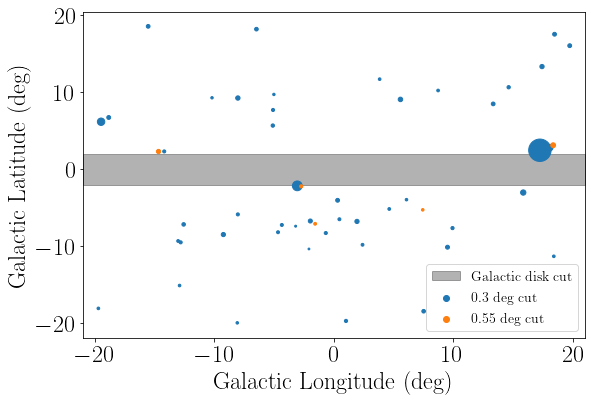

In [19]:
sizes = fluxes*2e12
sizes_extra = fluxes_extra*2e12
print(np.min(sizes))

plt.fill_between([-21, 21], [2, 2], [-2, -2], color='k', alpha=0.3, label="Galactic disk cut")
plt.xlim(-21, 21)
plt.scatter(lons, lats, s=sizes)
plt.scatter(lons_extra, lats_extra, s=sizes_extra)
plt.scatter([], [], label="0.3 deg cut", color="C0")
plt.scatter([], [], label="0.55 deg cut", color="C1")
plt.xlabel("Galactic Longitude (deg)")
plt.ylabel("Galactic Latitude (deg)")
plt.legend()

1.0731612e-12 1.3719972e-09


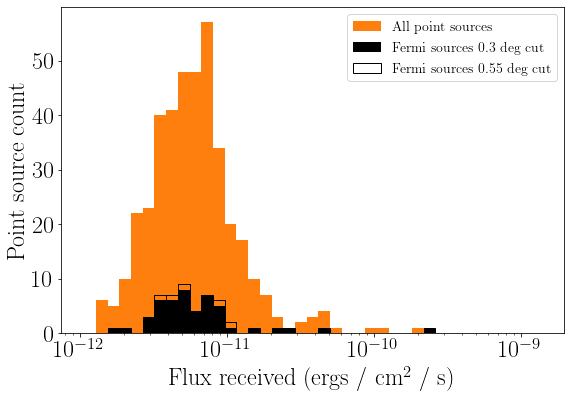

In [20]:
fluxData = fgl_data["Energy_Flux100"]
print(np.min(fluxData), np.max(fluxData))
bins = 10**np.linspace(start=np.log10(np.min(fluxData)), stop=np.log10(np.max(fluxData)), num=40)


plt.hist(fluxData, bins=bins, label="All point sources", color='C1')
plt.xlabel("Flux received (ergs / cm$^2$ / s)")
plt.ylabel("Point source count")
plt.xscale('log')


plt.hist(fluxes, bins=bins, color='black', label="Fermi sources 0.3 deg cut");
plt.hist(np.concatenate((fluxes, fluxes_extra)), bins=bins, color='black', fill=False, label="Fermi sources 0.55 deg cut");

plt.legend()

In [21]:
sorted_fluxes = fluxes.copy()
sorted_fluxes.sort()
print("Sum of all visible fluxes:", np.sum(sorted_fluxes))
print("Sum of all visible fluxes excluding the brightest:", np.sum(sorted_fluxes[:-1]))
print("Ratio of fluxes:", np.sum(sorted_fluxes[:-1]) / np.sum(sorted_fluxes))

Sum of all visible fluxes: 5.9159294e-10
Sum of all visible fluxes excluding the brightest: 3.4041164e-10
Ratio of fluxes: 0.5754153


# Predict histogram for each luminosity function

alpha = 1.94, L_min = 1e+29, L_max = 1e+35

L0 = 8.8e+33, sigma = 0.62

L0 = 1.6084e+32, sigma = 0.7003

L_break = 8.65649e+33, n1 = -0.66, n2 = 18.2



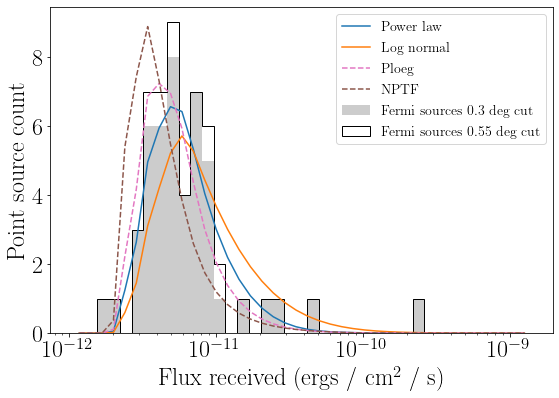

In [22]:
def display(data_file, label, color, style, normalize=True):
    f = open(data_file)
    header = f.readline()
    print(header)
    predicted_counts = np.asarray([float(i) for i in f.readline().split(",")[:-1]])
    predicted_fluxes = np.asarray([float(i) for i in f.readline().split(",")[:-1]])
    if normalize:
        predicted_counts *= len(fluxes) / sum(predicted_counts)
    f.close()

    plt.plot(predicted_fluxes, predicted_counts, label=label, c=color, linestyle=style)
    
    plt.xlabel("Flux received (ergs / cm$^2$ / s)")
    plt.ylabel("Point source count")
    plt.xscale('log')
    plt.legend()
    
display("../luminosity-models-position/data-1x/power-law/flux-hist.txt", "Power law", 'C0', 'solid')
display("../luminosity-models-position/data-1x/log-normal/flux-hist.txt", "Log normal", 'C1', 'solid')
display("../luminosity-models-position/data-1x/ploeg/flux-hist.txt", "Ploeg", 'C6', 'dashed')
display("../luminosity-models-position/data-1x/nptf/flux-hist.txt", "NPTF", 'C5', 'dashed')
plt.hist(fluxes, bins=bins, color=(0.8, 0.8, 0.8), label="Fermi sources 0.3 deg cut")
#plt.hist(fluxes, bins=bins, color='black', histtype='step')
plt.hist(list(fluxes) + list(fluxes_extra), bins=bins, color='black', histtype='step', label="Fermi sources 0.55 deg cut")
plt.legend();

alpha = 1.94, L_min = 1e+29, L_max = 1e+35

L0 = 8.8e+33, sigma = 0.62

L0 = 1.6084e+32, sigma = 0.7003

L_break = 8.65649e+33, n1 = -0.66, n2 = 18.2



(0.0, 11.0)

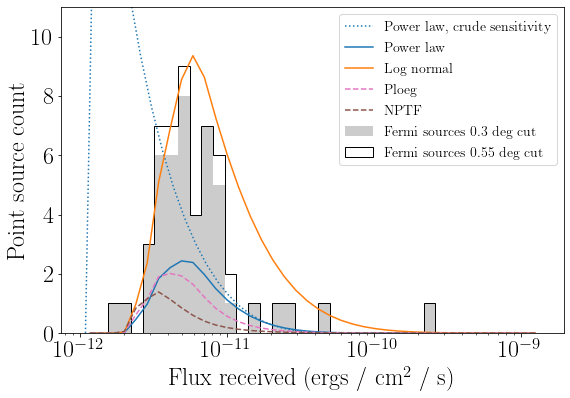

In [26]:
f = open("power-law-step/power-law-step.txt", 'r')
step_bins = [float(i) for i in f.readline().split(', ')[:-1]]
step_fluxes = [float(i) for i in f.readline().split(', ')[:-1]]
plt.plot(step_bins, step_fluxes, linestyle='dotted', color="C0", label="Power law, crude sensitivity")
display("../luminosity-models-position/data-1x/power-law/flux-hist.txt", "Power law", 'C0', 'solid', False)
display("../luminosity-models-position/data-1x/log-normal/flux-hist.txt", "Log normal", 'C1', 'solid', False)
display("../luminosity-models-position/data-1x/ploeg/flux-hist.txt", "Ploeg", 'C6', 'dashed', False)
display("../luminosity-models-position/data-1x/nptf/flux-hist.txt", "NPTF", 'C5', 'dashed', False)


plt.hist(fluxes, bins=bins, color=(0.8, 0.8, 0.8), label="Fermi sources 0.3 deg cut")
#plt.hist(fluxes, bins=bins, color='black', histtype='step')
plt.hist(list(fluxes) + list(fluxes_extra), bins=bins, color='black', histtype='step', label="Fermi sources 0.55 deg cut")
plt.legend();
plt.ylim(0, 11)

In [24]:
def get_unscaled_count(data_file):
    f = open(data_file)
    header = f.readline()
    predicted_counts = np.asarray([float(i) for i in f.readline().split(",")[:-1]])
    f.close()
    return np.sum(predicted_counts)

print("Comparisons are from the position-dependent case without the histogram breakdown.")
print(get_unscaled_count("../luminosity-models-position/data-1x/power-law/flux-hist.txt"), "Compare 17.613695")
print(get_unscaled_count("../luminosity-models-position/data-1x/log-normal/flux-hist.txt"), "Compare 77.489204")
print(get_unscaled_count("../luminosity-models-position/data-1x/ploeg/flux-hist.txt"), "Compare 13.406038")
print(get_unscaled_count("../luminosity-models-position/data-1x/nptf/flux-hist.txt"), "Compare 7.481112")

Comparisons are from the position-dependent case without the histogram breakdown.
17.451424003139998 Compare 17.613695
76.974802123 Compare 77.489204
13.06202127447 Compare 13.406038
7.3413045381287745 Compare 7.481112


In [25]:
print("The GCE would have to be more luminous by")
print(len(fluxes) / get_unscaled_count("../luminosity-models-position/data-1x/power-law/flux-hist.txt"))
print(len(fluxes) / get_unscaled_count("../luminosity-models-position/data-1x/log-normal/flux-hist.txt"))
print(len(fluxes) / get_unscaled_count("../luminosity-models-position/data-1x/ploeg/flux-hist.txt"))
print(len(fluxes) / get_unscaled_count("../luminosity-models-position/data-1x/nptf/flux-hist.txt"))

The GCE would have to be more luminous by
2.6931899649875786
0.610589422820438
3.5982179949333344
6.402131903927232
